<h1>X-mode propagation Study</h1>

This notebok serves as a playing field for the user to get acquainted with the WavesPlasma library, as well as allowing to run a series of tests to make sure everything is running smoothly.

In [1]:
import numpy as np
import cmath as cm

from scipy.fft import fft,fftfreq
from scipy.interpolate import make_smoothing_spline

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import clear_output

import copy
from timeit import default_timer as timer

np.random.seed(2024061) # For reproducibility

import import_ipynb
from WavesPlasma import *

Nx     = 2100
p0plas = 90        
k00    = 0.025     # rads/point
ν      = 84        # GHz
wpe2_,wc_ = freq_dicts(Nx,k00,p0plas)

importing Jupyter notebook from WavesPlasma.ipynb


Testing the plasma_domain class.

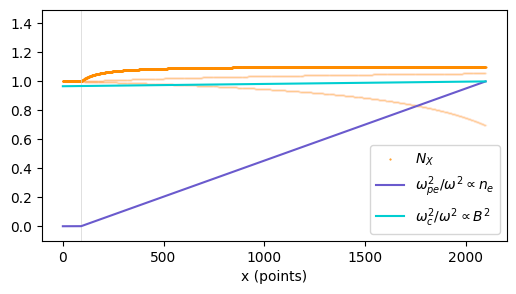

In [2]:
plas=plasma_domain(wpe2_['default'],wc_['default'],Nx,p0plas,k00,ν,info=False)
plas.plot(0.999*k00,kimin=0.98*k00,kimax=1.03*k00)

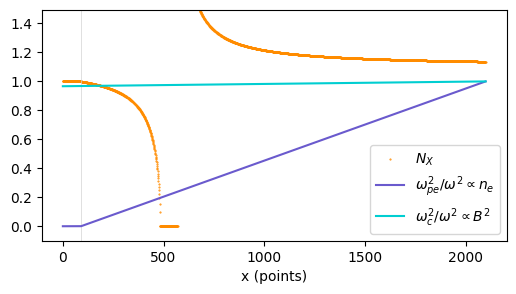

In [3]:
plas.plot(1.005*k00)

<h3>Probing wave</h3>

The wave we will be using to excite the cavity will be a sinusoidal wave enveloped by a smooth evolving function. We add this envelope to avoid frequency components inherent to the step function, as if we only send a sinusoidal wave starting at a time $t_0$ what we are really sending is $\sin(...)H(t-t_0)$, where $H$ is the Heaviside or step function. Hence we will be really interested in the response when the envelope has reached maximum amplitude. To shut-off the excitation we do the same operation.

An example of a well-behaved wave in this regard is the following, which is the default excitation wave defined in the mathematica code.

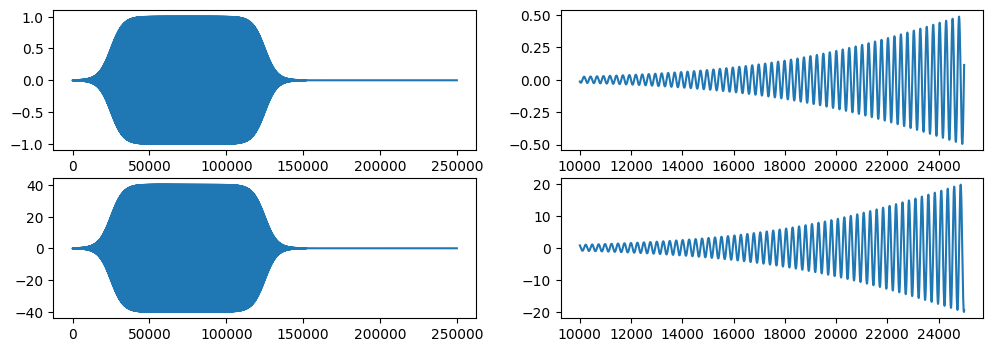

In [4]:
Nt  = 250000    # Time iterations

# -- Envelope function parameters --
t0l=25000
t0r=125000
slope=0.000125

# -- underlying Sinusoidal parameters--
srt = 300000    # Sweeping rate time (explanation below)

      # --             Envelope function             -- #          # --           ki            -- #
Extc=[0.5*(np.tanh(slope*(t-t0l))-np.tanh(slope*(t-t0r)))*np.sin(t*k00*(0.995+0.02*(t-5000)/(2*srt))) for t in range(Nt)]

CumulativeExtc=np.zeros(Nt)
CumulativeExtc[0]=Extc[0]
for i in range(1,len(CumulativeExtc)): CumulativeExtc[i]=CumulativeExtc[i-1]+Extc[i]

fig,axs=plt.subplots(2,2,figsize=(12,4))
axs[0,0].plot(Extc)
axs[1,0].plot(CumulativeExtc)
axs[0,1].plot(np.arange(10000,25000),Extc[10000:25000])
axs[1,1].plot(np.arange(10000,25000),CumulativeExtc[10000:25000])
plt.show()

Let us explain what the sweeping rate is. When probing the plasma we want to do so at different frequencies to obtain more information. We call the sweep range the range of frequencies of the probing wave, which in our case goes from 50 to 120 GHz (all microwave frequencies). The sweeping rate is the rate at which the probing frequency changes, and thus, the sweep time (here called sweeping rate time) is the total time over which this change is carried out. We can see above that the sweep range is 

\begin{equation}
    k_{i}\in\left[0.995-\frac{\texttt{sr}}{100\texttt{srt}},0.995+\frac{\texttt{Nt}-\texttt{sr}}{100\texttt{srt}}\right]\cdot k_{00}=\left[0.99484,1.00317\right]\cdot k_{00}\quad\implies\quad\lambda_{i}\in[252.63,250.53]\text{ grid points}\ ,
\end{equation}

where the values of ```Nt```, ```sr``` and ```srt``` are those found in the mathematica code. We can also see that in our case the sweeping rate is linear.

**This allows us to study what happens on both sides of the index divergence to study the X-mode cutt-off near the plasma edge.**

<h3>Plasma Modelling</h3>

We begin by initialising the plasma.

In [5]:
Nt = 1000

wv = wavePlasma(plas,
                ki = lambda t: OGkiSweep(t,k00,sr=1000,srt=3000),
                sExc = OGsource)
wv.reset()

startRunTime=timer()
wv.waveEvPlasma(Nt,plot=False)
endRunTime=timer()

print("Total running time: %.3f"%(endRunTime-startRunTime))

Total running time: 21.756, left 0h 0m 0s


<h3>Homogeneus non-magnetised plasma - Gaussian pulse</h3>

A wide gaussian pulse has a very narrow frequency spectrum, meaning that the reflected wave is considerably stronger than for narrow time pulses. Below we represent a fast pulse (very wide in the frequency spectrum).

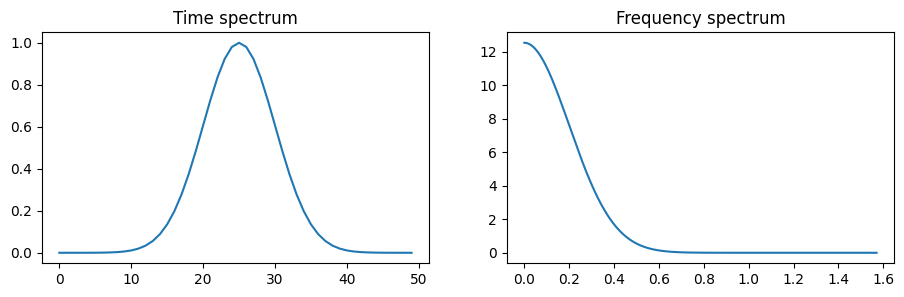

In [6]:
N=10000
σ=5
gt=np.array([gaussSource(t,k00,σ) for t in range(N)])
plot_freqSpectrum(gt,10*σ,4)

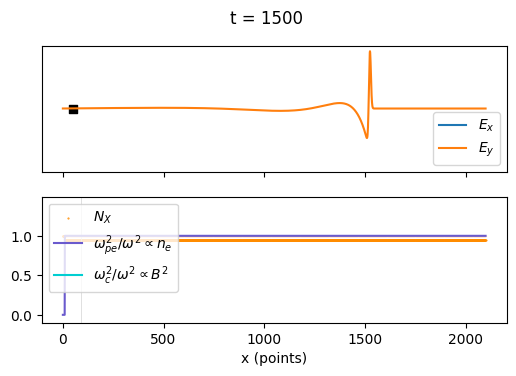

In [7]:
wavePlasma(plasma_domain(wpe2_['constant'],wc_['vacuum']),
           ki = lambda t: k0i(t,k00),
           sExc = lambda t,ki: gaussSource(t,ki,σ),
           sPos = 50
          ).waveEvPlasma(Nt=1500)

In this case the pulse propagates with very little contribution to the reflected wave (see the left-hand side of the emitter).

<h2>Time of flight computation</h2>

We want to study the time of flight in magnetised plasma, but let us start first with the unmagnetised case to verify the correct behaviour of the code.

<h4>Unmag plasma - Time of flight for constant frequency sinusoidal waves</h4>

We will study the time of flight for constant probing frequency for both linear and parabolic profiles. We know that the times of flight for those frequencies are:

$$\tau_\text{linear}(\omega)=\frac{4}{c}x_c(\omega)\qquad\tau_\text{parabolic}(\omega)=\frac{\pi}{c}x_c(\omega)$$

Note that if we send a simple sinusoidal wave we are not operating at a fixed frequency. The fact that the sinusoidal excitation starts suddenly implies a relatively strong contribution of many different frequencies on top of the sinusoidal excitation. To avoid this contribution we are going to envelope the sinusoidal with a gaussian. To make as small as possible the frequency contributions of the gaussian envelope we want to make it as wide as possible. Hence we are going to take an excitation that fits 20 wavelengths in the $[\mu-\sigma,\mu+\sigma]$ interval.

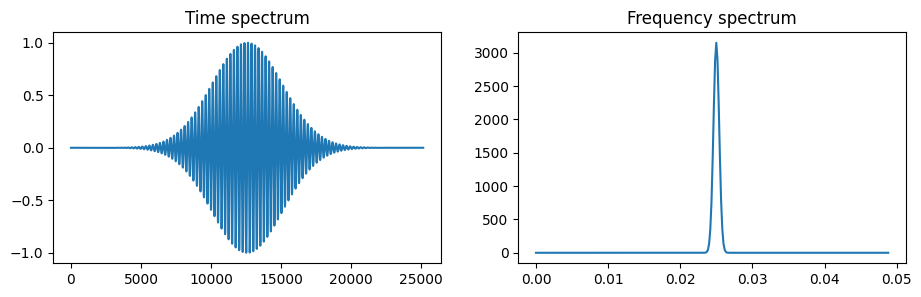

<string>:69: RuntimeWarning: invalid value encountered in scalar divide


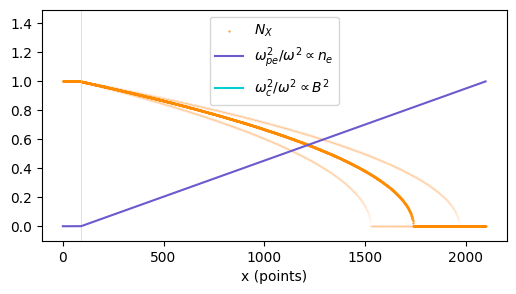

In [8]:
λinσ=10 # We will have λinσ*2 wavelengths in the interval

σ=λinσ*2*np.pi/k00
Nt= int(np.ceil(5*σ))*3
gt=[gaussSource(t,k00,σ)*sinSource(t,k00) for t in range(Nt)]

plot_freqSpectrum(gt,2*Nt//3,128)

kimin,kimax=freq_minmax(gt)
plas=plasma_domain(wpe2_['buffer'],wc_['vacuum'])
plas.plot(k00,kimin=kimin,kimax=kimax)

It is nice to play around with the value of ```λinσ``` to see the effect on the frequency spectrum. The bigger its value the more defined is the frequency peak around $k_{00}$. Despite this, however wide we make the gaussian envelope there will always be frequency contributions close to $k_{00}$. We want to be able to determine the range of frequencies to know the plasma index for the minimal and maximal contributions.

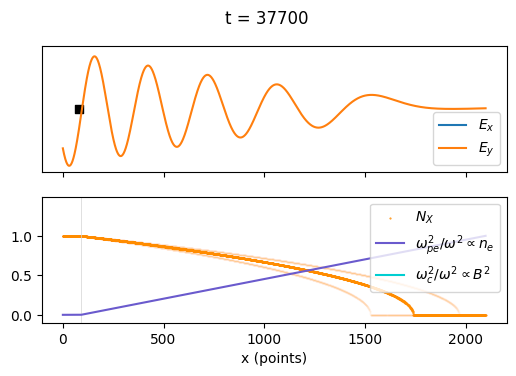

Total running time: 1499.121


In [9]:
wv=wavePlasma(plas,
           ki = lambda t: k0i(t,k00),
           sExc = lambda t,ki: gaussSource(t,ki,σ)*sinSource(t,ki)
          )

startRunTime=timer()
wv.waveEvPlasma(Nt=Nt,Hist=True)
endRunTime=timer()

print("Total running time: %.3f"%(endRunTime-startRunTime))

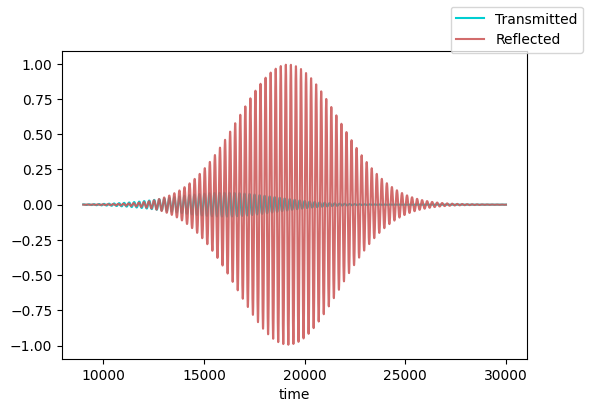

Numerical time of flight:   6609.672456279484 
Theoretical time of flight: 6626


In [10]:
wv.plot_TransReflect(interv=(9000,30000))

# Time of flight

xcpos=wv.plasma.cut_offLoc(k00)

print('Numerical time of flight:   '+str(wv.time_of_flight()),
     '\nTheoretical time of flight: '+str(4*(xcpos-wv.plasma.p0plas)+(wv.plasma.p0plas-wv.sPos)+(wv.plasma.p0plas-(wv.sPos-2))))

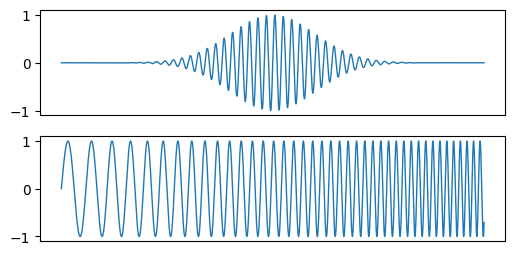

0.5663199999999999


In [11]:
sr=17000
srt=250
σplot = 5*2*np.pi/k00
Ntplot=int(10*σplot)
sGaussPlot=[gaussSource(t,k00,σplot)*sinSource(t,k00) for t in range(Ntplot)]
sSweepPlot=[np.sin(OGkiSweep(t,k00,sr,srt)*t) for t in range(Ntplot)]

folderpath='Results/'
saveplots=1

fig,axs=plt.subplots(2,1,figsize=(6,3))
axs[0].plot(sGaussPlot,linewidth=1)
axs[1].plot(sSweepPlot,linewidth=1)
for ax in axs: ax.set_xticks([])
if saveplots: plt.savefig(folderpath+'probing_comp.png',bbox_inches='tight',transparent=True,dpi=500)
plt.show()

print(OGkiSweep(Ntplot//2,k00,sr,srt)/k00)